# Import Libraries

In [11]:
import os
import zipfile
import shutil
from sklearn.model_selection import train_test_split
from collections import Counter
import random
import numpy as np
from tensorflow.keras.utils import to_categorical
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Ignore all warnings
warnings.filterwarnings('ignore')

# Load Dataset

In [12]:
# Path to the ZIP file containing the dataset
dataset_zip_path = "/content/Traffic sign dataset.zip"
extract_path = "/content/Traffic sign dataset/Traffic sign dataset/Traffic sign dataset"

# Extracting the ZIP file
if not os.path.exists(extract_path):
    with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# Paths to train and test directories
train_dir = os.path.join(extract_path, "train")
test_dir = os.path.join(extract_path, "test")

# Checking the train and test directories
print("Train Directory: ", train_dir)
print("Test Directory: ", test_dir)

# Reading images and splitting the test dataset into test and validation
test_images = [os.path.join(test_dir, img) for img in os.listdir(test_dir) if img.endswith(".png")]
train_images = [os.path.join(train_dir, img) for img in os.listdir(train_dir) if img.endswith(".png")]

# Splitting the test dataset into test and validation sets (80% test and 20% validation)
test_images, val_images = train_test_split(test_images, test_size=0.2, random_state=42)

# Creating a new directory for storing validation data
val_dir = os.path.join(extract_path, "validation")
if not os.path.exists(val_dir):
    os.makedirs(val_dir)

# Moving validation images to the validation folder
for img_path in val_images:
    shutil.move(img_path, os.path.join(val_dir, os.path.basename(img_path)))
print(f"Number of train images: {len(train_images)}")
print(f"Number of test images: {len(test_images)}")
print(f"Number of validation images: {len(val_images)}")


Train Directory:  /content/Traffic sign dataset/Traffic sign dataset/Traffic sign dataset/train
Test Directory:  /content/Traffic sign dataset/Traffic sign dataset/Traffic sign dataset/test
Number of train images: 4170
Number of test images: 1276
Number of validation images: 319


# cheking for balance

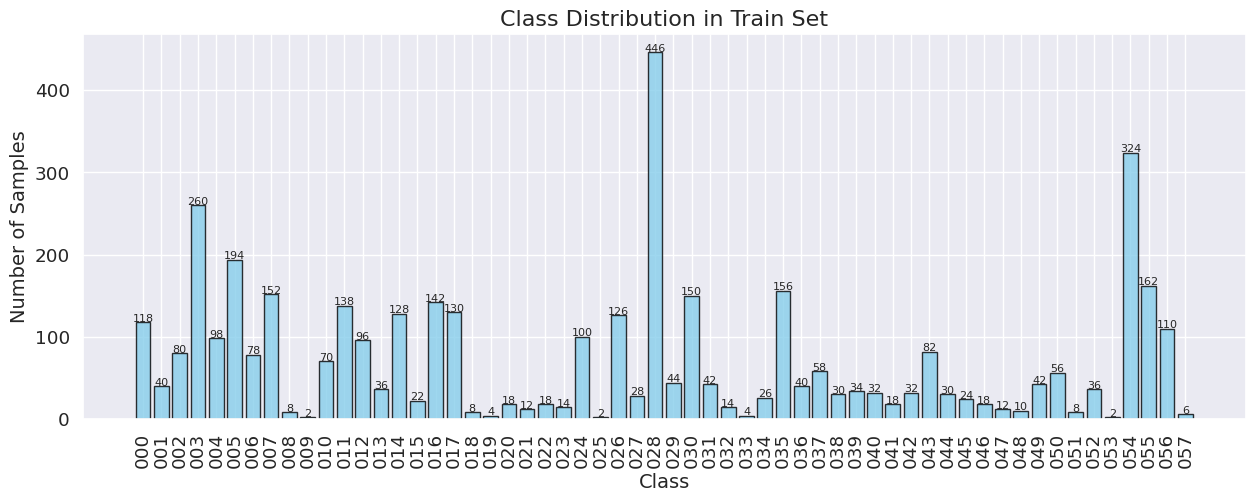

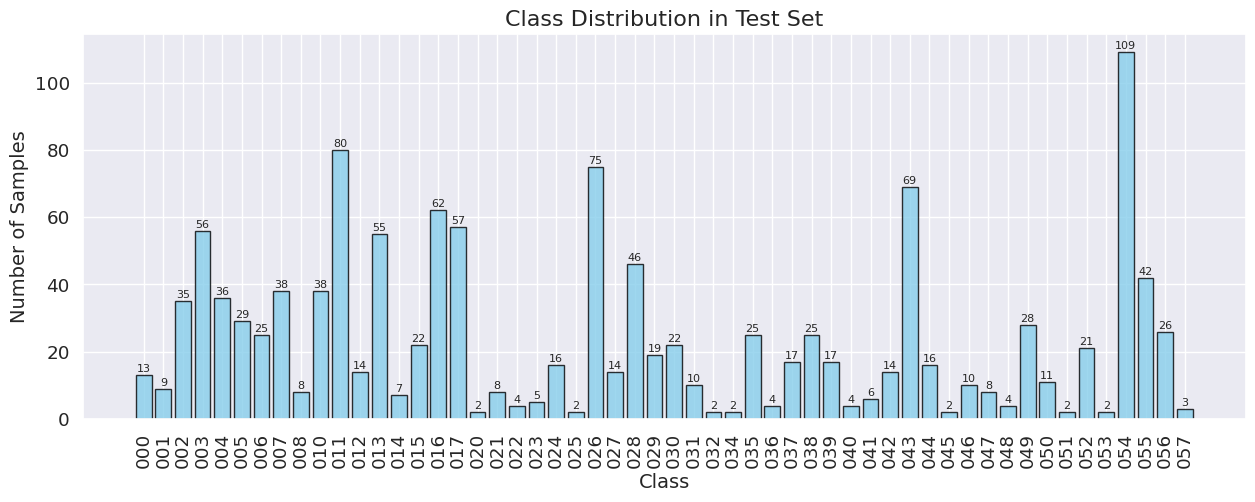

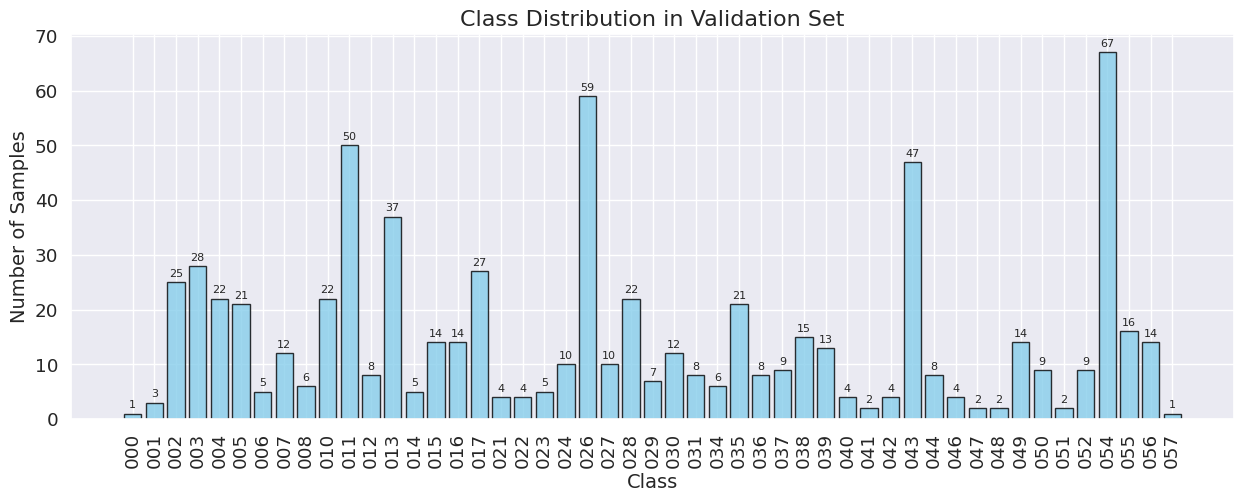

In [13]:
extract_path = "/content/Traffic sign dataset/Traffic sign dataset/Traffic sign dataset"

def extract_classes_from_filenames(filenames):
    """
    Extract classes from filenames (the first 3 characters of the filename represent the class)
    """
    classes = [os.path.basename(fname)[:3] for fname in filenames]
    return classes

def plot_class_distribution(class_counts, title, output_path=None):
    """
    Plot histogram of class distribution
    """
    classes = sorted(class_counts.keys())
    counts = [class_counts[c] for c in classes]

    plt.figure(figsize=(15, 5))
    plt.bar(classes, counts, color='skyblue', alpha=0.8, edgecolor='black')
    plt.title(title, fontsize=16)
    plt.xlabel("Class", fontsize=14)
    plt.ylabel("Number of Samples", fontsize=14)
    plt.xticks(rotation=90)

    # Displaying sample counts on the histogram
    for i, count in enumerate(counts):
        plt.text(i, count + 1, str(count), ha='center', fontsize=8)

    if output_path:
        plt.savefig(output_path, bbox_inches='tight')
    plt.show()

# Paths to directories
train_dir = os.path.join(extract_path, "train")
test_dir = os.path.join(extract_path, "test")
val_dir = os.path.join('/content/Traffic sign dataset/Traffic sign dataset/Traffic sign dataset', "validation")

# Extracting the files for each set
train_files = [os.path.join(train_dir, img) for img in os.listdir(train_dir) if img.endswith(".png")]
test_files = [os.path.join(test_dir, img) for img in os.listdir(test_dir) if img.endswith(".png")]
val_files = [os.path.join(val_dir, img) for img in os.listdir(val_dir) if img.endswith(".png")]

# Extracting classes
train_classes = extract_classes_from_filenames(train_files)
test_classes = extract_classes_from_filenames(test_files)
val_classes = extract_classes_from_filenames(val_files)

# Counting the number of samples per class
train_counts = Counter(train_classes)
test_counts = Counter(test_classes)
val_counts = Counter(val_classes)

# Plotting histograms for each dataset
plot_class_distribution(train_counts, "Class Distribution in Train Set")
plot_class_distribution(test_counts, "Class Distribution in Test Set")
plot_class_distribution(val_counts, "Class Distribution in Validation Set")


# visulization

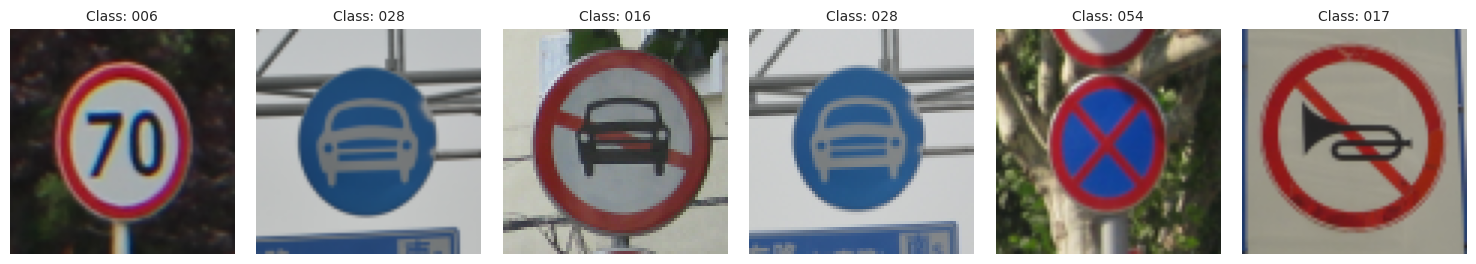

In [14]:
def display_sample_images(image_paths, num_samples=6):
    """
    Display samples of images along with their class labels
    """
    # Randomly select a number of images
    sample_images = random.sample(image_paths, num_samples)

    # Display settings
    plt.figure(figsize=(15, 5))

    for i, img_path in enumerate(sample_images):
        # Open the image
        image = Image.open(img_path)
        # Extract class from the filename
        class_label = os.path.basename(img_path)[:3]

        # Display the image
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image)
        plt.title(f"Class: {class_label}", fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display a few sample images from the train dataset
display_sample_images(train_files, num_samples=6)


# preprocessing

In [15]:
def preprocess_images_with_fixed_classes(image_paths, all_classes):
    """
    Preprocess images and labels using a fixed list of classes
    """
    images = []
    labels = []

    for img_path in image_paths:
        # Open the image
        image = Image.open(img_path).resize((75, 75))
        image = np.array(image) / 255.0  # Normalization
        images.append(image)

        # Extract class from the filename
        class_label = int(os.path.basename(img_path)[:3])
        labels.append(all_classes.index(class_label))

    # Convert to numpy arrays
    images = np.array(images)
    labels = to_categorical(labels, num_classes=len(all_classes))  # One-hot encoding
    return images, labels

# Define fixed list of classes
all_classes = list(range(58))  # Classes from 000 to 057

# Preprocess each dataset
train_images, train_labels = preprocess_images_with_fixed_classes(train_files, all_classes)
test_images, test_labels = preprocess_images_with_fixed_classes(test_files, all_classes)
val_images, val_labels = preprocess_images_with_fixed_classes(val_files, all_classes)

# Display shapes of the datasets
print(f"Train images shape: {train_images.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")
print(f"Validation images shape: {val_images.shape}")
print(f"Validation labels shape: {val_labels.shape}")


Train images shape: (4170, 75, 75, 3)
Train labels shape: (4170, 58)
Test images shape: (1276, 75, 75, 3)
Test labels shape: (1276, 58)
Validation images shape: (718, 75, 75, 3)
Validation labels shape: (718, 58)


# build network

Epoch 1/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 24s 187ms/step - accuracy: 0.1472 - loss: 10.7099 - val_accuracy: 0.0390 - val_loss: 12.1268
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.3792 - loss: 7.5280 - val_accuracy: 0.0390 - val_loss: 9.5341
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.5651 - loss: 5.3705 - val_accuracy: 0.0543 - val_loss: 7.4053
Epoch 4/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.6645 - loss: 4.0803 - val_accuracy: 0.1616 - val_loss: 5.6083
Epoch 5/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.7319 - loss: 3.2795 - val_accuracy: 0.2591 - val_loss: 4.7402
Epoch 6/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.8028 - loss: 2.6295 - val_accuracy: 0.3719 - val_loss: 4.0976
Epoch 7/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.8380 - loss: 2.2461 - val_accuracy: 0.4666 - val_loss: 3.3716
Epoch 8/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.8786 - loss: 1.8951 - val_accuracy

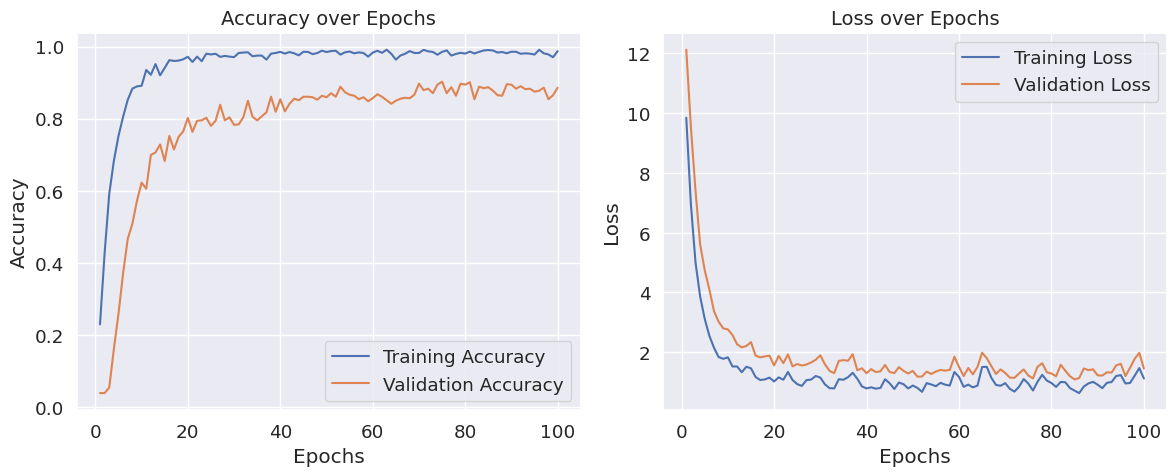

In [16]:
# Define CNN model
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', kernel_initializer=tf.keras.initializers.HeUniform(),
               input_shape=input_shape, padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        Conv2D(128, (3, 3), activation='relu', kernel_initializer=tf.keras.initializers.HeUniform(), padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        Conv2D(256, (3, 3), activation='relu', kernel_initializer=tf.keras.initializers.HeUniform(), padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.4),

        Conv2D(512, (3, 3), activation='relu', kernel_initializer=tf.keras.initializers.HeUniform(), padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.4),

        Flatten(),
        Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Define inputs
input_shape = (75, 75, 3)
num_classes = 58

# Create the model
model = create_cnn_model(input_shape, num_classes)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model and save history
history = model.fit(
    train_images, train_labels,
    epochs=100,
    batch_size=64,
    validation_data=(val_images, val_labels)
)

# Plot training history
def plot_training_history(history):
    epochs = range(1, len(history.history['accuracy']) + 1)

    # Accuracy plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs', fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs', fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Display the plots
plot_training_history(history)


# Evaluation

Test Accuracy: 0.89
Test Loss: 1.41
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


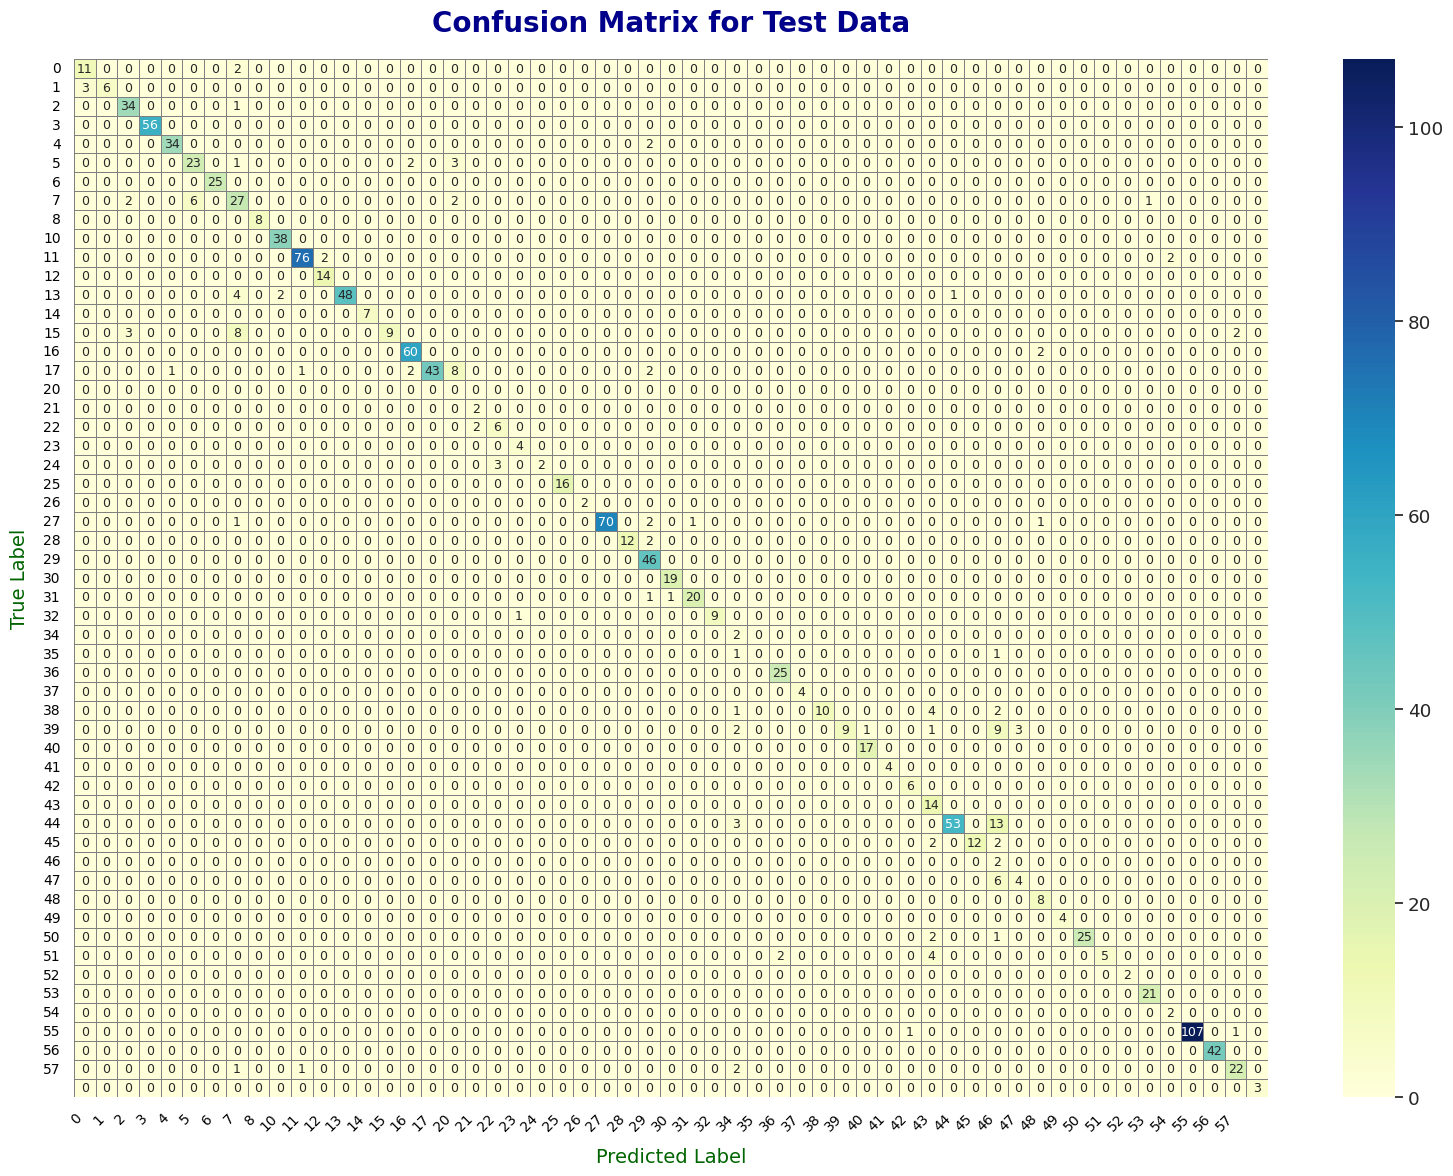

In [17]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Loss: {test_loss:.2f}")

# Predict classes on test data
test_predictions = model.predict(test_images)
test_pred_classes = np.argmax(test_predictions, axis=1)
test_true_classes = np.argmax(test_labels, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(test_true_classes, test_pred_classes)

# Set figure size and improve plot aesthetics
plt.figure(figsize=(16, 12))
sns.set(font_scale=1.2)  # Increase font size
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', cbar=True, linewidths=0.5, linecolor='gray',
            xticklabels=np.unique(test_true_classes), yticklabels=np.unique(test_true_classes), annot_kws={"size": 9})

# Add titles and labels with style
plt.title("Confusion Matrix for Test Data", fontsize=20, fontweight='bold', color='darkblue', pad=20)
plt.xlabel("Predicted Label", fontsize=14, labelpad=10, color='darkgreen')
plt.ylabel("True Label", fontsize=14, labelpad=10, color='darkgreen')
plt.xticks(rotation=45, ha='right', fontsize=10, color='black')
plt.yticks(fontsize=10, color='black')

# Improve spacing for better appearance
plt.tight_layout()

# Display the plot
plt.show()


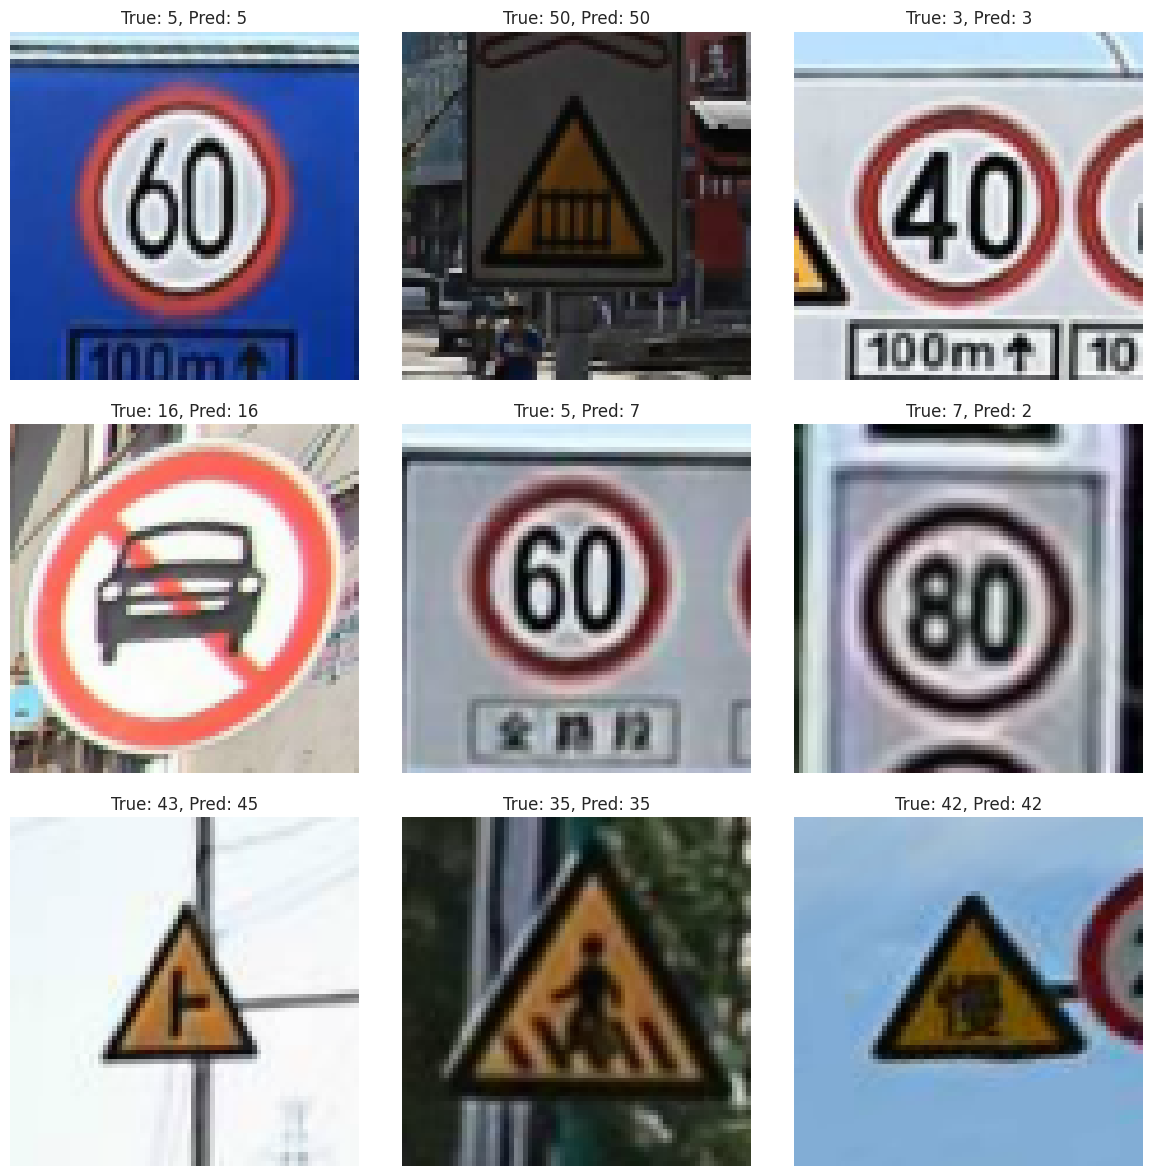

In [18]:
# Number of samples to display
num_samples = 9

# Randomly select a few test images
random_indices = random.sample(range(len(test_images)), num_samples)
sample_images = test_images[random_indices]
sample_true_labels = test_true_classes[random_indices]
sample_pred_labels = test_pred_classes[random_indices]

# Display the samples
plt.figure(figsize=(12, 12))
for i in range(num_samples):
    plt.subplot(3, 3, i + 1)  # Create a 3x3 grid to display images
    plt.imshow(sample_images[i])  # Display the image
    true_label = sample_true_labels[i]
    pred_label = sample_pred_labels[i]
    plt.title(f"True: {true_label}, Pred: {pred_label}", fontsize=12)
    plt.axis("off")  # Remove axes
plt.tight_layout()
plt.show()
